# Algorithm Walk-Through

This notebook will walkthrough the preprocessing steps as well as the ML algorithm training procedure used for the multi-dimensional, multi-output data. 

## Experiment Overview

## Code

### Packages

In [143]:
import sys
sys.path.insert(0, "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/src")

# Standard packages
import numpy as np
import pandas as pd

# Datasets
from data.make_dataset import DataLoader, load_standard_data, load_high_dim_data, load_labels, get_data

# Experiments

# Features
from features.pca_features import transform_all, transform_individual
from features.analysis import get_stats
from sklearn.preprocessing import StandardScaler
from data.make_dataset import ValidationFloats
from features.build_features import run_input_preprocess, run_input_postprocess, run_output_preprocess, run_output_postprocess, run_split

# ML Models
from sklearn.model_selection import train_test_split
from models.baseline import train_rf_model
import statsmodels.api as smi

# Visualization
from visualization.visualize import plot_mo_stats, plot_geolocations, get_depth_labels
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
class DataParams:
    region = 'na'

class ProcessParams:
    n_components = 10
    valid_split = 0.2
    input_std = "before"
    pca_seed = 123
    bootstrap_seed = 123
    std_ouputs = True


In [168]:
def run_experiment():
    
    # Load Data
    dataset = get_data(DataParams)
        
    # Run Inputs Preprocessing
    dataset = run_input_preprocess(ProcessParams, dataset)
    
    # Run Outputs Preprocessing
    dataset = run_output_preprocess(ProcessParams, dataset)
    
    # Train Test Split
    dataset = run_split(ProcessParams, dataset)
    
    
    
    # Run Inputs PostProcessing
    if ProcessParams.input_std == 'after':
        dataset = run_input_postprocess(ProcessParams, dataset)
    
    # Run Outputs Post Processing
    if ProcessParams.std_ouputs:
        dataset = run_output_postprocess(ProcessParams, dataset)
    
    return dataset

In [169]:
class DataParams:
    region = 'na'

class ProcessParams:
    n_components = 3
    valid_split = 0.2
    input_std = "after"
    pca_seed = 123
    bootstrap_seed = 111
    std_ouputs = False

dataset = run_experiment()

print('Training:')
print(dataset['Xtrain'].shape, dataset['ytrain'].shape)
print('Validation:')
print(dataset['Xvalid'].shape, dataset['yvalid'].shape)
print('Testing:')
print(dataset['Xtest'].shape, dataset['ytest'].shape)

Training:
(2288, 25) (2288, 276)
Validation:
(572, 25) (572, 276)
Testing:
(162, 25) (162, 276)


---
### 5 - Train ML Model

In [146]:
from models.baseline import train_glm_model, train_gp_model, train_mlp_model, train_lr_model, train_mo_rf_model

#### 5.1 - Linear Regression

In [190]:
model = train_lr_model(dataset['Xtrain'], dataset['ytrain'])

#### 5.2 - Elastic Net (Cross-Validated)

In [194]:
model = train_glm_model(dataset['Xtrain'], dataset['ytrain'], verbose=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 36.9min finished


Training time: 2213.772 secs.


#### 5.3 - (2-Layer) MultiPerceptron Model

In [191]:
model = train_mlp_model(dataset['Xtrain'], dataset['ytrain'], verbose=1, valid=0.1)

Iteration 1, loss = 0.00416137
Iteration 2, loss = 0.00068648
Iteration 3, loss = 0.00039337
Iteration 4, loss = 0.00030998
Iteration 5, loss = 0.00027829
Iteration 6, loss = 0.00026240
Iteration 7, loss = 0.00025241
Iteration 8, loss = 0.00024606
Iteration 9, loss = 0.00024184
Iteration 10, loss = 0.00023826
Iteration 11, loss = 0.00023532
Iteration 12, loss = 0.00023327
Iteration 13, loss = 0.00023190
Iteration 14, loss = 0.00023089
Iteration 15, loss = 0.00023006
Iteration 16, loss = 0.00022928
Iteration 17, loss = 0.00022861
Training loss did not improve more than tol=0.000010 for 10 consecutive epochs. Stopping.
Training time: 1.475 secs.


#### 5.4 - Random Forest Model

In [170]:
model = train_rf_model(dataset['Xtrain'], dataset['ytrain'], verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:    6.2s


Training time: 8.609 secs.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.2s finished


#### 5.5 - Gaussian Process

In [62]:
model = train_gp_model(dataset['Xtrain'], dataset['ytrain'], verbose=1)

.................................

Training time: 645.112 secs.


---
### 6 - Test ML Model

#### 6.1 - Training Data Results

This is often not reported but it is very good to check how well a model does on the initial training data because we have no entered a validation set. If we find that the training stats are too high and the testing stats are very low then we know that we're either overfitting and/or our model is not generalizing very well.

First we will look at the statistics on average to see what we get.

In [51]:
ypred = model.predict(dataset['Xtrain'])

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.2s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.4s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.7s
[Parallel(n_jobs=28)]: Done 1000 out of 1000 | elapsed:    0.9s finished


(4.99999987368938e-05, 0.0042500000687937)

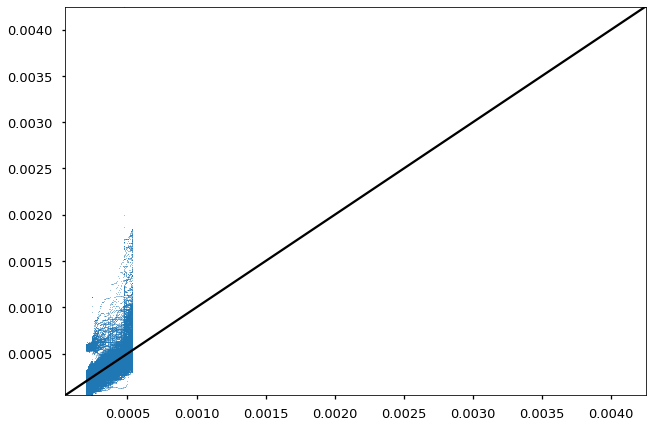

In [52]:
min_lim = np.min(np.concatenate((ypred, dataset['ytrain'])))
max_lim = np.max(np.concatenate((ypred, dataset['ytrain'])))


plt.scatter(ypred, dataset['ytrain'], s=0.1)
plt.plot(np.linspace(min_lim, max_lim), np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
plt.ylim([min_lim, max_lim])

In [53]:
stat_mod = smi.OLS(ypred.ravel(), dataset['ytrain'].values.ravel())

res = stat_mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                          2.921e+06
Date:                Mon, 27 Jan 2020   Prob (F-statistic):                        0.00
Time:                        16:17:08   Log-Likelihood:                      2.3169e+06
No. Observations:              298632   AIC:                                 -4.634e+06
Df Residuals:                  298631   BIC:                                 -4.634e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [10]:
# each level
each_level = False

stats = get_stats(ypred, dataset['ytrain'], each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.000126,6.666512e-08,6.666512e-08,0.520664


Then we can look at the statistics for each level.

In [12]:
class PlotParams:
    model = 'gp'
    region = 'na'
#     validation_float = 

In [13]:
each_level = True

stats_df = get_stats(ypred, dataset['ytrain'], each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.000528,5.160252e-07,0.000718,0.736775
1,0.000528,5.181832e-07,0.000720,0.745604
2,0.000540,5.429829e-07,0.000737,0.748379
3,0.000546,5.485013e-07,0.000741,0.754323
4,0.000555,5.678645e-07,0.000754,0.750353


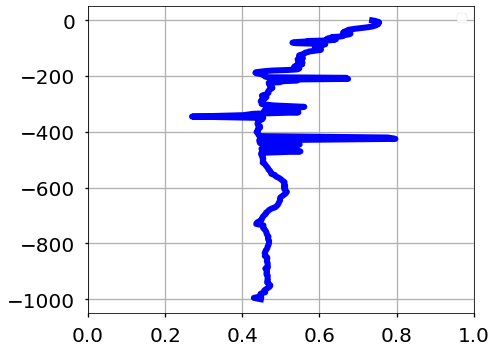

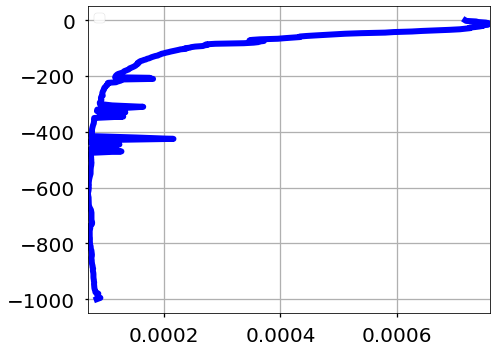

In [15]:
statistic = 'r2'

plt.style.use('seaborn-talk')
plot_mo_stats(stats_df, stat='r2', save_name='na_train_rf')
plot_mo_stats(stats_df, stat='rmse', save_name='na_train_rf')

#### 6.2 - Testing Data Results

In [16]:
ypred = model.predict(dataset['Xvalid'])

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.3s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.5s
[Parallel(n_jobs=28)]: Done 1000 out of 1000 | elapsed:    0.6s finished


In [17]:
ypred.shape, dataset['yvalid'].shape

((572, 276), (572, 276))

(9.99999974737875e-06, 0.00908999983221292)

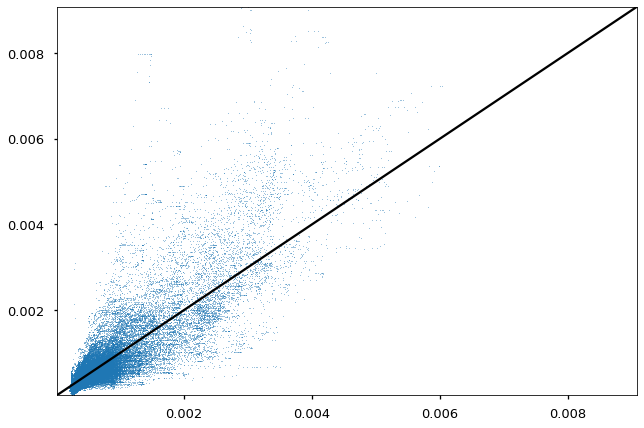

In [18]:
min_lim = np.min(np.concatenate((ypred, dataset['yvalid'])))
max_lim = np.max(np.concatenate((ypred, dataset['yvalid'])))


plt.scatter(ypred, dataset['yvalid'], s=0.1)
plt.plot(np.linspace(min_lim, max_lim), np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
plt.ylim([min_lim, max_lim])

In [19]:
dataset['yvalid'].shape

(572, 276)

In [20]:
stat_mod = smi.OLS(ypred.ravel(), dataset['yvalid'].values.ravel())

res = stat_mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.851
Model:                            OLS   Adj. R-squared (uncentered):              0.851
Method:                 Least Squares   F-statistic:                          8.999e+05
Date:                Mon, 27 Jan 2020   Prob (F-statistic):                        0.00
Time:                        16:09:01   Log-Likelihood:                      1.0674e+06
No. Observations:              157872   AIC:                                 -2.135e+06
Df Residuals:                  157871   BIC:                                 -2.135e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

((36708,), (74796,))

In [79]:
each_level = True

stats_df = get_stats(ypred.ravel(), dataset['ytest'].values.ravel(), each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.000041,2.374942e-08,0.000154,0.444236


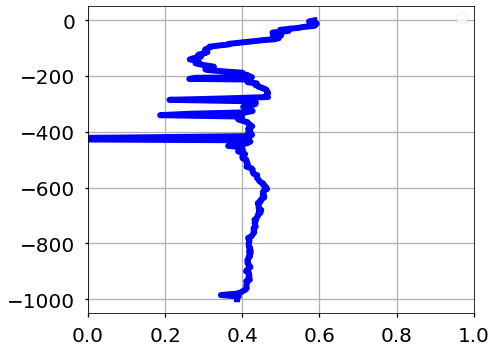

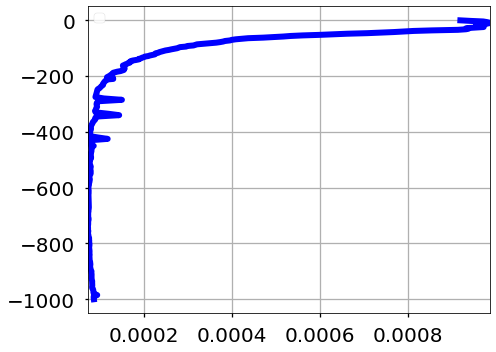

In [22]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(stats_df, stat='r2', save_name='stg_test_lr')
plot_mo_stats(stats_df, stat='rmse', save_name='stg_test_lr')

#### 6.3 - Validation Profile

In [192]:
ypred = model.predict(dataset['Xtest'])

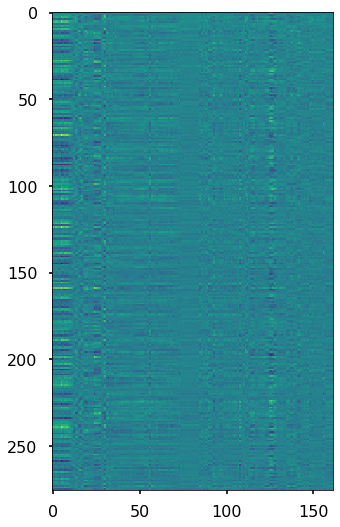

In [193]:
plt.imshow(ypred.T)

In [173]:
from data.make_dataset import load_labels, get_depth_labels


In [174]:
# initialize class
valid_getter = ValidationFloats('na')

# get validation floats
valid_getter.get_validation_floats('na')

[6901486, 3902123]

In [175]:
dat = load_labels('na', training=False)

In [176]:
dat.iloc[:, 2:] = ypred

In [177]:
dat.iloc[:, 2:].shape, ypred.shape

((162, 276), (162, 276))

In [178]:
dat.shape, ypred.shape

((162, 278), (162, 276))

In [179]:
ypred.shape

(162, 276)

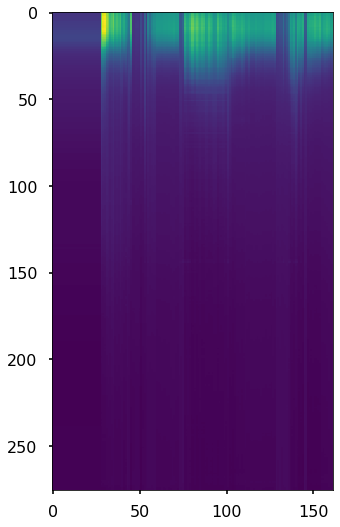

In [180]:
plt.imshow(dat.iloc[:, 2:].T)

In [185]:
floatname = 6901486 # 6901486 #3902123
region = 'na'
float1 = dat[dat['wmo'] == floatname].drop(labels=['wmo'], axis=1)

y_labels = float1['n_cycle']

float1 = float1.iloc[:, 1:]

x_labels = get_depth_labels()

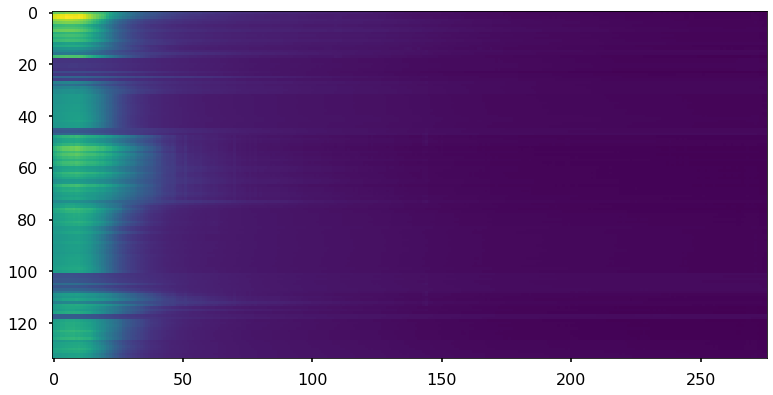

In [186]:
plt.imshow(float1)

In [187]:
x_labels.shape, y_labels.shape, float1.T.shape

((276,), (134,), (276, 134))

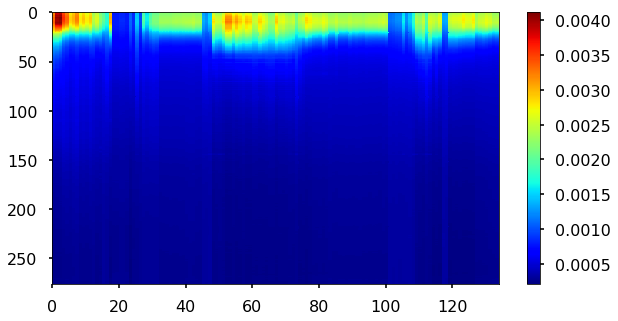

In [188]:
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"
model = 'lr'

fig, ax = plt.subplots(figsize=(10,5))

pts = ax.pcolormesh(float1.T, cmap='jet')
# ax.set_yticklabels(x_labels)
plt.colorbar(pts)
plt.gca().invert_yaxis()
plt.savefig(SAVE_PATH + f"{region}_y_heatmap_{floatname}_pred_{model}")

In [189]:
ypred

array([[0.00080337, 0.0008108 , 0.00081676, ..., 0.00023846, 0.0002382 ,
        0.00023511],
       [0.00080337, 0.0008108 , 0.00081676, ..., 0.00023846, 0.0002382 ,
        0.00023511],
       [0.00080337, 0.0008108 , 0.00081676, ..., 0.00023846, 0.0002382 ,
        0.00023511],
       ...,
       [0.00239909, 0.00245266, 0.00245466, ..., 0.00025948, 0.0002564 ,
        0.00025564],
       [0.00226838, 0.00230615, 0.00231382, ..., 0.00026283, 0.00025985,
        0.0002591 ],
       [0.00227483, 0.00231239, 0.00232158, ..., 0.00026426, 0.00026129,
        0.00026049]])

In [191]:
float1 = dataset['ytest'][dataset['ytest'] == 3902121]

In [192]:
float1.shape

(133, 276)

In [281]:
# initialize class
valid_getter = ValidationFloats('stg')

# get validation floats
valid_getter.get_validation_floats('stg')

[6901472, 3902121]

In [172]:


# get timeseries
y_validation = valid_getter.get_validation_res(ypred, dataset['ytest'], 0)

y_validation.head()

(133, 2) (133, 276)


,n_cycle,Depth,Predictions,Test
0,3.0,0,0.000522,0.000474
1,4.0,0,0.000575,0.000474
2,5.0,0,0.000573,0.000474
3,6.0,0,0.000565,0.000474
4,7.0,0,0.000540,0.000474


In [173]:
stat_mod = smi.OLS(y_validation['Predictions'].ravel(), y_validation['Test'].ravel())

res = stat_mod.fit()
r2_val = res.rsquared
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.824
Model:                            OLS   Adj. R-squared (uncentered):              0.824
Method:                 Least Squares   F-statistic:                          1.400e+05
Date:                Mon, 27 Jan 2020   Prob (F-statistic):                        0.00
Time:                        16:46:08   Log-Likelihood:                      2.1701e+05
No. Observations:               29808   AIC:                                 -4.340e+05
Df Residuals:                   29807   BIC:                                 -4.340e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [174]:
model_name = 'rf'
ifloat = 6901472


In [175]:
import seaborn as sns

<Figure size 720x720 with 0 Axes>

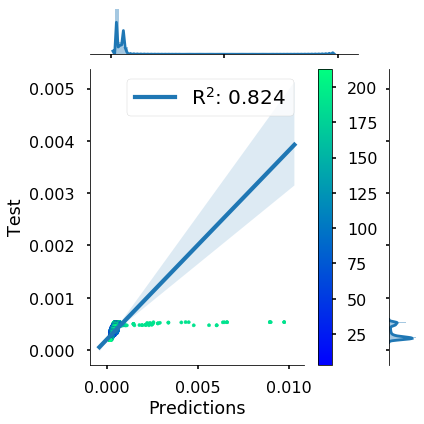

In [176]:
plt.figure(figsize=(10,10))
g = sns.jointplot(x="Predictions", y="Test", data=y_validation, kind='reg', scatter=False)
pts = g.ax_joint.scatter(x='Predictions', y='Test', c='n_cycle', data=y_validation, cmap='winter', s=10)
plt.colorbar(pts)
plt.tight_layout()
plt.legend([fr'R$^2$: {r2_val:.3f}'], fontsize=20)
plt.savefig(SAVE_PATH + f'stg_valid_m{model_name}_f{ifloat}_time' + '.png')
plt.show()

<Figure size 720x720 with 0 Axes>

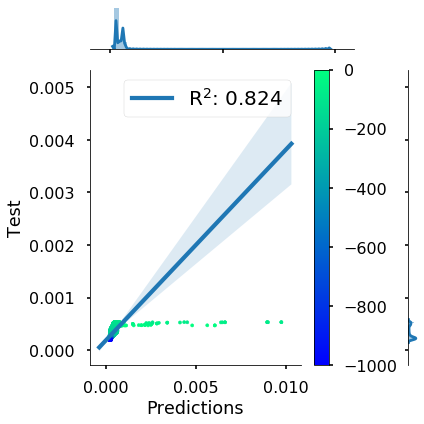

In [177]:
plt.figure(figsize=(10,10))
g = sns.jointplot(x="Predictions", y="Test", data=y_validation, kind='reg', scatter=False)
pts = g.ax_joint.scatter(x='Predictions', y='Test', c='Depth', data=y_validation, cmap='winter', s=10)
plt.colorbar(pts)
plt.tight_layout()
plt.legend([fr'R$^2$: {r2_val:.3f}'], fontsize=20)
plt.savefig(SAVE_PATH + f'stg_valid_m{model_name}_f{ifloat}_depth' + '.png')
plt.show()

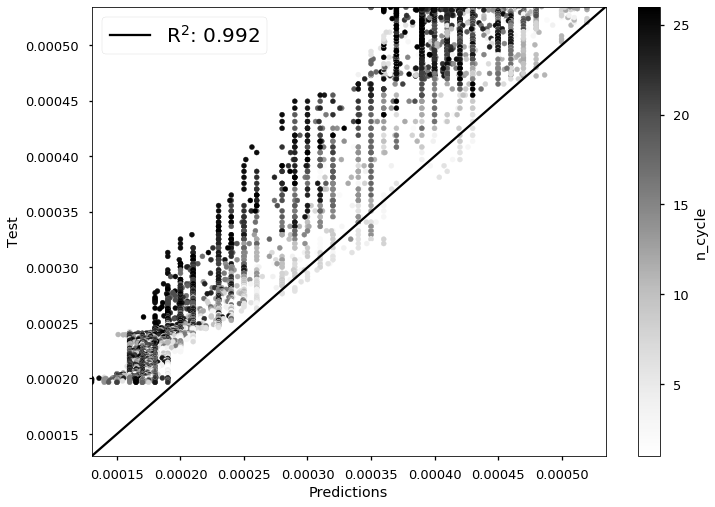

In [85]:
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"

r2_val = res.rsquared
slope = res.params[0]

min_lim = y_validation[['Predictions', 'Test']].min().min()
max_lim = y_validation[['Predictions', 'Test']].max().max()

plt.style.use('seaborn-talk')
fig, ax = plt.subplots()
y_validation.plot.scatter(ax=ax, x='Predictions', y='Test', c='n_cycle', s=25)
ax.plot(np.linspace(min_lim, max_lim), np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
plt.ylim([min_lim, max_lim])
plt.tight_layout()
plt.legend([fr'R$^2$: {r2_val:.3f}'], fontsize=20)
plt.savefig(SAVE_PATH + f'na_valid_m{model_name}_f{ifloat}_t' + '.png')
plt.show()

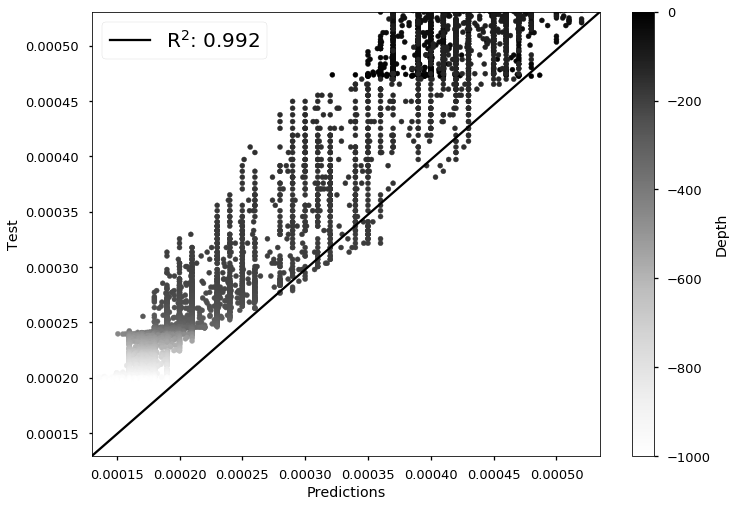

In [64]:
SAVE_PATH = "/home/emmanuel/figures/ml4ocn/"

xlim = y_validation[['Predictions']].min()
max_lim = y_validation[['Predictions', 'Test']].max()

plt.style.use('seaborn-talk')
fig, ax = plt.subplots()
y_validation.plot.scatter(ax=ax, x='Predictions', y='Test', c='Depth', s=25)
ax.plot(np.linspace(min_lim, max_lim), r2_val * np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
# plt.ylim([r2_val * min_lim, r2_val * max_lim])
plt.tight_layout()
plt.legend([fr'R$^2$: {r2_val:.3f}'], fontsize=20)
plt.savefig(SAVE_PATH + f'na_valid_m{model_name}_f{ifloat}_d' + '.png')
plt.show()

In [444]:
# each level
each_level = False

stats = get_stats(ypred, dataset['ytest'], each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.0002,2.580603e-07,2.580603e-07,-0.53396


In [445]:
each_level = True

stats_df = get_stats(ypred, dataset['ytest'], each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.001149,0.000002,0.001466,-0.076087
1,0.001200,0.000002,0.001544,-0.081775
2,0.001238,0.000003,0.001606,-0.085894
3,0.001290,0.000003,0.001673,-0.091362
4,0.001343,0.000003,0.001753,-0.099165


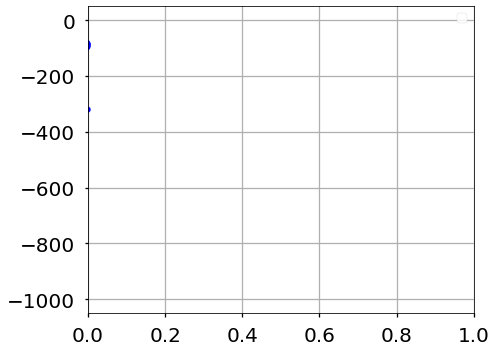

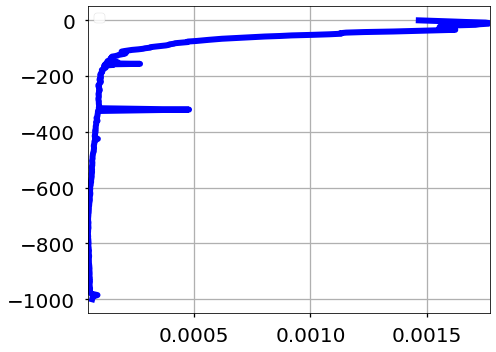

In [446]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(stats_df, stat='r2', save_name='valid_mlp')
plot_mo_stats(stats_df, stat='rmse', save_name='valid_mlp')

---
### 7 - Post Analysis

#### 7.1 - Feature Importance

For some algorithms, we can calculate the feature importance based on the inputs dimensions. This is true for the random forest model.

In [135]:
rf_model.

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [39]:
tree_feature_importances = \
    rf_model.feature_importances_

feature_names = np.asarray(new_columns) #np.concatenate((core_columns.values, np.array(pca_columns)))

assert feature_names.shape[0] == tree_feature_importances.shape[0], "Shapes don't match"

sorted_idx = tree_feature_importances.argsort()

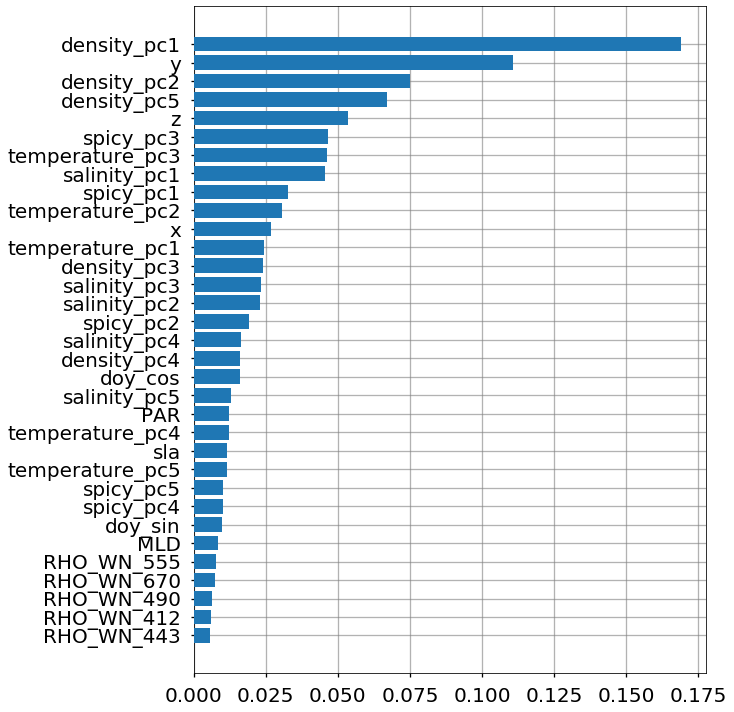

In [40]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'na'
y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx], zorder=3, height=0.8)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
plt.tight_layout()
plt.show()
# fig.savefig(SAVE_PATH + f"fi_{save_name}.png")

#### 7.2 - Permutation Plot

In [179]:
perm_result_test = permutation_importance(
    rf_model, 
    Xtest, 
    ytest, 
    n_repeats=10,
    random_state=42, 
    n_jobs=1
)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:    0.7s finished
/home/emmanuel/.conda/envs/ml4ocn/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", Futu

In [36]:
sorted_idx = perm_result_test.importances_mean.argsort()

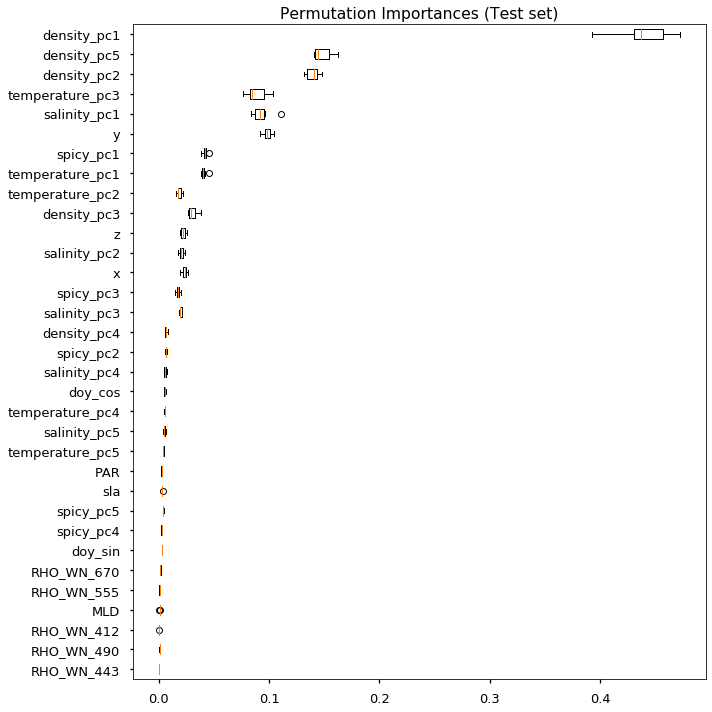

In [182]:
fig, ax = plt.subplots(figsize=(10,10))
plt.style.use(['seaborn-talk'])
ax.boxplot(
    perm_result_test.importances[sorted_idx].T,
    vert=False, 
    labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (Test set)")
fig.tight_layout()
plt.show()

In [38]:
perm_result_train = permutation_importance(
    rf_model, 
    Xtrain, 
    ytrain, 
    n_repeats=10,
    random_state=42, 
    n_jobs=1
)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:    2.3s finished
/home/emmanuel/.conda/envs/ml4ocn/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", Futu

KeyboardInterrupt: 

In [ ]:
sorted_idx = perm_result_train.importances_mean.argsort()

In [ ]:
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots()
ax.boxplot(
    perm_result_train.importances[sorted_idx].T,
    vert=False, 
    labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (Train set)")
fig.tight_layout()
plt.show()

## Subtropical Gyros

#### Load Data

In [143]:
X_core = load_standard_data('STG', training=True)

# Testing Data
X_core_te = load_standard_data('STG', training=False)


X_core_te = X_core_te.iloc[:, 2:]

X_core.shape, X_core_te.shape

((1353, 11), (133, 11))

In [144]:
X_temp, X_dens, X_sal, X_spicy = load_high_dim_data('STG', training=True)

# add prefix (Training/Validation)
X_temp = X_temp.add_prefix('temp_')
X_dens = X_dens.add_prefix('dens_')
X_sal = X_sal.add_prefix('sal_')
X_spicy = X_spicy.add_prefix('spice_')

# 
X_temp_te, X_dens_te, X_sal_te, X_spicy_te = load_high_dim_data('STG', training=False)


# Subset
X_temp_te = X_temp_te.iloc[:, 2:] 
X_dens_te = X_dens_te.iloc[:, 2:] 
X_sal_te= X_sal_te.iloc[:, 2:]
X_spicy_te = X_spicy_te.iloc[:, 2:]

# add prefix (Test)
X_temp_te = X_temp_te.add_prefix('temp_')
X_dens_te = X_dens_te.add_prefix('dens_')
X_sal_te = X_sal_te.add_prefix('sal_')
X_spicy_te = X_spicy_te.add_prefix('spice_')

In [145]:
y = load_labels('STG', training=True)

yte = load_labels('STG', training=False)

yte = yte.iloc[:, 2:]


In [146]:
# Training Data
Xtr = pd.concat([
    X_core, 
    X_temp, 
    X_dens, 
    X_sal, 
    X_spicy
], axis=1)



# Testing Data
Xte = pd.concat([
    X_core_te, 
    X_temp_te, 
    X_dens_te, 
    X_sal_te, 
    X_spicy_te
], axis=1)

#### Tre Transformations

In [154]:
# new columns columns
temp_columns = X_temp.columns.values
dens_columns = X_dens.columns.values
sal_columns = X_sal.columns.values
spicy_columns = X_spicy.columns.values
core_columns = ['sla', "PAR","RHO_WN_412","RHO_WN_443","RHO_WN_490","RHO_WN_555","RHO_WN_670","MLD"]
time_columns = ['doy']
loc_columns = ['lat', 'lon']

n_components = 5
times = ['doy']

new_columns = [
    *["doy_cos", "doy_sin"], 
    *['x', 'y', 'z',],
    *[f"temperature_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"density_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"salinity_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"spicy_pc{icomponent+1}" for icomponent in range(n_components)],
    *core_columns, 
]
seed = 123
# define transfomer
X_transformer = ColumnTransformer(
    [   ("time", CycleTransform(times), time_columns),
        ("space", GeoCartTransform(), loc_columns),
        ('temp', PCA(n_components=n_components, random_state=seed), temp_columns),
        ('dens', PCA(n_components=n_components, random_state=seed), dens_columns),
        ('sal', PCA(n_components=n_components, random_state=seed), sal_columns),
        ('spice', PCA(n_components=n_components, random_state=seed), spicy_columns),
#         ('core', StandardScaler(with_mean=True, with_std=True), core_columns)
    ],
    remainder='passthrough'
)
# fit transform to data
X_transformer.fit(Xtr)

# transform data
Xtrain = X_transformer.fit_transform(Xtr)
Xtest = X_transformer.transform(Xte)

In [155]:
ytrain = np.log(y)
ytest = np.log(yte)

ytrain.shape, ytest.shape

((1353, 276), (133, 276))

#### Train-Test Split

In [156]:
Xtrain, Xvalid, ytrain, yvalid =  train_test_split(
        Xtrain, ytrain,
        train_size=.8, random_state=1
    )


#### Post Transformations

In [157]:
X_transformer = StandardScaler(with_mean=True, with_std=True)

# fit transform to data
X_transformer.fit(Xtrain)

# transform data
Xtrain = X_transformer.fit_transform(Xtrain)
Xvalid = X_transformer.transform(Xvalid)
Xtest = X_transformer.transform(Xtest)

In [158]:
output_transformer = StandardScaler(with_mean=True, with_std=False)

ytrain = output_transformer.fit_transform(ytrain)
yvalid = output_transformer.fit_transform(yvalid)
ytest = output_transformer.transform(ytest)

#### Train ML Model

In [159]:
model = train_mlp_model(Xtrain, ytrain, verbose=1, valid=0.1)

Iteration 1, loss = 0.04404014
Iteration 2, loss = 0.04233716
Iteration 3, loss = 0.03999879
Iteration 4, loss = 0.03553489
Iteration 5, loss = 0.02922904
Iteration 6, loss = 0.02270823
Iteration 7, loss = 0.01774804
Iteration 8, loss = 0.01455149
Iteration 9, loss = 0.01275994
Iteration 10, loss = 0.01139479
Iteration 11, loss = 0.01041543
Iteration 12, loss = 0.00956958
Iteration 13, loss = 0.00893924
Iteration 14, loss = 0.00837105
Iteration 15, loss = 0.00784597
Iteration 16, loss = 0.00745897
Iteration 17, loss = 0.00710062
Iteration 18, loss = 0.00689064
Iteration 19, loss = 0.00659195
Iteration 20, loss = 0.00644984
Iteration 21, loss = 0.00620834
Iteration 22, loss = 0.00599103
Iteration 23, loss = 0.00585093
Iteration 24, loss = 0.00571502
Iteration 25, loss = 0.00557472
Iteration 26, loss = 0.00544984
Iteration 27, loss = 0.00532607
Iteration 28, loss = 0.00522278
Iteration 29, loss = 0.00508456
Iteration 30, loss = 0.00503143
Iteration 31, loss = 0.00501642
Iteration 32, los

#### Test ML Model

In [103]:
ypred = model.predict(Xtest)
# each level
each_level = False

stats = get_stats(ypred, ytest, each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.076336,0.011636,0.011636,0.812559


In [104]:
each_level = True

stats_df = get_stats(ypred, ytest, each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.088556,0.020310,0.142513,0.717452
1,0.081911,0.015445,0.124277,0.762677
2,0.076586,0.011129,0.105496,0.814074
3,0.081023,0.013181,0.114808,0.789395
4,0.073182,0.009919,0.099596,0.820807


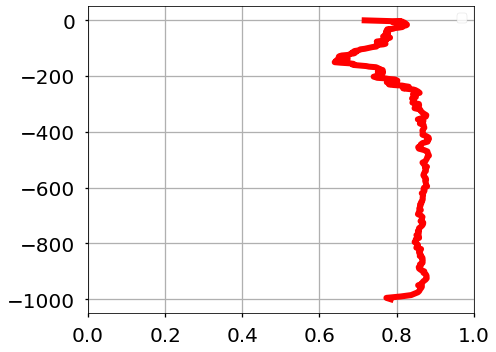

In [109]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(
    stats_df, 
    stat='r2', 
    save_name='stg_test',
    color='red'
)

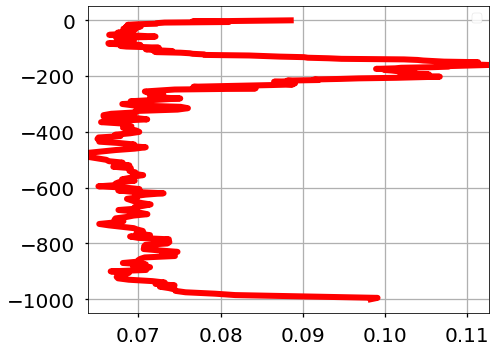

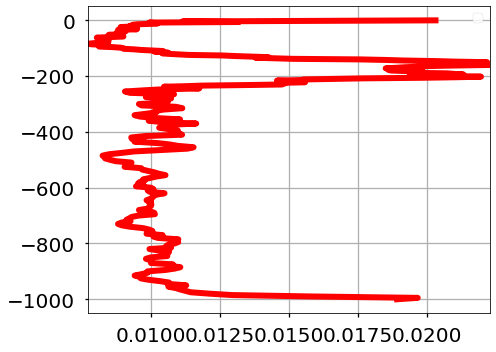

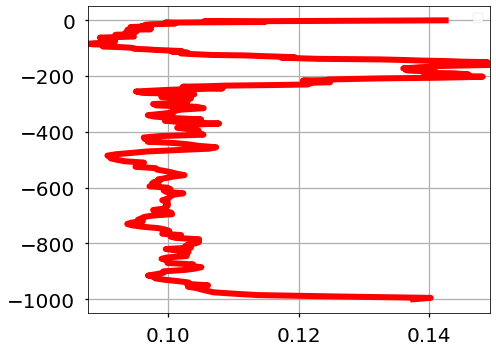

In [110]:
plot_mo_stats(stats_df, stat='mae', save_name='stg_test', color='red')
plot_mo_stats(stats_df, stat='mse', save_name='stg_test', color='red')
plot_mo_stats(stats_df, stat='rmse', save_name='stg_test', color='red')

#### Post Analysis

In [53]:
tree_feature_importances = \
    rf_model.feature_importances_

feature_names = np.asarray(new_columns) #np.concatenate((core_columns.values, np.array(pca_columns)))

assert feature_names.shape[0] == tree_feature_importances.shape[0], "Shapes don't match"

sorted_idx = tree_feature_importances.argsort()

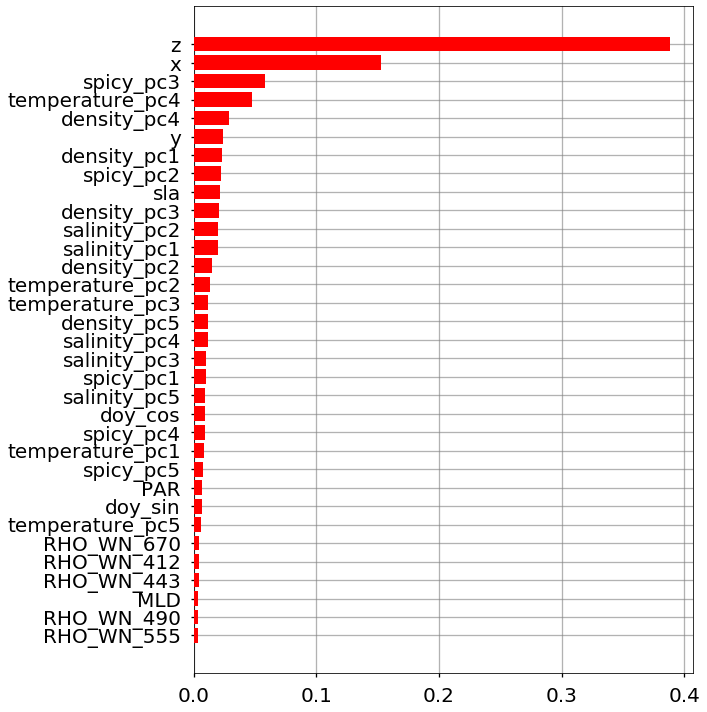

In [54]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'stg'
y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx], zorder=3, height=0.8, color='red')
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
plt.tight_layout()
plt.show()
fig.savefig(SAVE_PATH + f"fi_{save_name}.png")

In [105]:
depths = 276
first = [*range(1, 250)]
d1 = first[::2]

second = [*range(251,1000)]
d2 = second[::5]


In [106]:
len(d1), len(d2)

(125, 150)

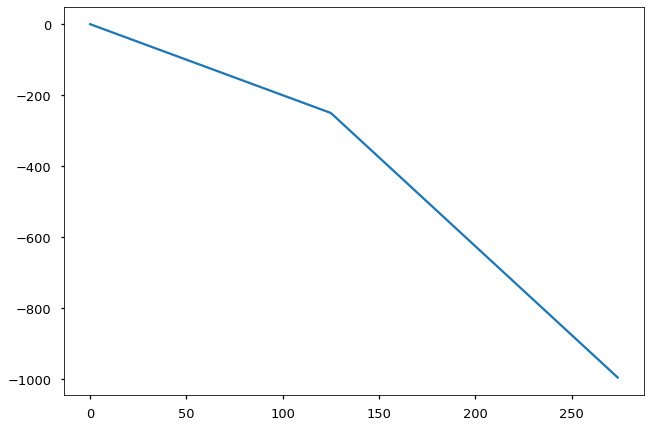

In [109]:
plt.plot(-np.concatenate((d1,d2)))